In [59]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, concatenate, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Cropping2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import MeanIoU

In [2]:
TRAIN_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images"
TRAIN_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/GroundTruth"
TEST_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images"
TEST_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/GroundTruth"

In [3]:
import kagglehub
kagglehub.dataset_download('muhammadasifwazir/diabetic-retinopathy-dataset')

'/kaggle/input/diabetic-retinopathy-dataset'

In [4]:
def create_combined_mask(image_filename):
    sample_mask_path = os.path.join(TRAIN_MASK_DIR, mask_subfolders[0], image_filename)
    mask_shape = cv2.imread(sample_mask_path, cv2.IMREAD_GRAYSCALE).shape
    combined_mask = np.zeros(mask_shape, dtype=np.uint8)

    for subfolder in mask_subfolders:
        mask_path = os.path.join(TRAIN_MASK_DIR, subfolder, image_filename)
        if os.path.exists(mask_path):
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            combined_mask = cv2.bitwise_or(combined_mask, mask)

    return combined_mask

In [5]:
OUTPUT_MASK_DIR = "/kaggle/working/CombinedMasksTask1"
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
mask_subfolders = ['CWS', 'HE']
image_filenames = os.listdir(TRAIN_IMAGE_DIR)

for image_filename in tqdm(image_filenames):
    combined_mask = create_combined_mask(image_filename)
    output_path = os.path.join(OUTPUT_MASK_DIR, image_filename)
    cv2.imwrite(output_path, combined_mask)

100%|██████████| 130/130 [00:04<00:00, 27.01it/s]


In [6]:
OUTPUT_MASK_DIR = "/kaggle/working/CombinedMasksTask2"
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
mask_subfolders = ['H', 'MA']
image_filenames = sorted(os.listdir(TRAIN_IMAGE_DIR))

for image_filename in tqdm(image_filenames):
    combined_mask = create_combined_mask(image_filename)
    output_path = os.path.join(OUTPUT_MASK_DIR, image_filename)
    cv2.imwrite(output_path, combined_mask)

100%|██████████| 130/130 [00:04<00:00, 27.87it/s]


In [7]:
OUTPUT_MASK_DIR = "/kaggle/working/TestCombinedMasksTask1"
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
mask_subfolders = ['CWS', 'HE']
image_filenames = os.listdir(TEST_IMAGE_DIR)

for image_filename in tqdm(image_filenames):
    combined_mask = create_combined_mask(image_filename)
    output_path = os.path.join(OUTPUT_MASK_DIR, image_filename)
    cv2.imwrite(output_path, combined_mask)

100%|██████████| 89/89 [00:01<00:00, 49.26it/s]


In [8]:
OUTPUT_MASK_DIR = "/kaggle/working/TestCombinedMasksTask2"
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)
mask_subfolders = ['H', 'MA']
image_filenames = os.listdir(TEST_IMAGE_DIR)

for image_filename in tqdm(image_filenames):
    combined_mask = create_combined_mask(image_filename)
    output_path = os.path.join(OUTPUT_MASK_DIR, image_filename)
    cv2.imwrite(output_path, combined_mask)

100%|██████████| 89/89 [00:01<00:00, 47.58it/s]


In [9]:
IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images"
MASK_DIR = "/kaggle/working/CombinedMasksTask1"

IMG_HEIGHT = 1152
IMG_WIDTH = 1500
BATCH_SIZE = 1
EPOCHS = 50

def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    images = []
    masks = []
    
    for filename in tqdm(image_filenames, desc="Loading data"):
        # Load and resize image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        #image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        images.append(image)  # Normalize image to [0, 1]
        
        # Load and resize mask
        mask_path = os.path.join(mask_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 0).astype(np.uint8)  # Binarize mask (0 or 1)
        masks.append(mask)
    
    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

images, masks = load_data(IMAGE_DIR, MASK_DIR)

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.1, random_state=42)

Loading data: 100%|██████████| 130/130 [00:08<00:00, 14.49it/s]


In [22]:
def build_unet(input_shape=(1152, 1500, 3)):
    inputs = Input(shape=input_shape)

    x = ZeroPadding2D(padding=((0,0),(2,2)))(inputs)  # shape => (1152, 1504, 3)

    # -------- Encoder --------
    c1 = Conv2D(64, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)  # shape => (576, 752)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)  # (288, 376)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)  # (144, 188)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)  # (72, 94)

    # -------- Bottleneck --------
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # -------- Decoder --------
    u6 = UpSampling2D((2, 2))(c5)           # (144, 188)
    u6 = concatenate([u6, c4])             # both (144,188) => OK
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)          # (288, 376)
    u7 = concatenate([u7, c3])             # both (288,376)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)          # (576, 752)
    u8 = concatenate([u8, c2])             # both (576,752)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)          # (1152,1504)
    u9 = concatenate([u9, c1])             # both (1152,1504)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    c9_cropped = Cropping2D(cropping=((0,0),(2,2)))(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9_cropped)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[MeanIoU(num_classes=2)]
    )

    return model

Epoch 1/50


2025-01-06 21:15:57.056346: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,1152,1502]{3,2,1,0}, f32[3,1,1152,1500]{3,2,1,0}), window={size=1152x1500 pad=1_1x0_0 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-01-06 21:15:58.492855: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.436600775s
Trying algorithm eng0{} for conv (f32[64,3,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,1152,1502]{3,2,1,0}, f32[3,1,1152,1500]{3,2,1,0}), window={size=1152x1500 pad=1_1x0_0 rhs_reversal=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

110/110 ━━━━━━━━━━━━━━━━━━━━ 169s 860ms/step - loss: 3.0261 - mean_io_u_6: 0.4978 - val_loss: 0.0036 - val_mean_io_u_6: 0.4997
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 828ms/step - loss: 0.0141 - mean_io_u_6: 0.5020 - val_loss: 0.0039 - val_mean_io_u_6: 0.4997
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 830ms/step - loss: 0.0107 - mean_io_u_6: 0.5067 - val_loss: 0.0038 - val_mean_io_u_6: 0.4997
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 847ms/step - loss: 0.0071 - mean_io_u_6: 0.5207 - val_loss: 0.0034 - val_mean_io_u_6: 0.4997
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 845ms/step - loss: 0.0093 - mean_io_u_6: 0.5019 - val_loss: 0.0033 - val_mean_io_u_6: 0.4997
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 93s 846ms/step - loss: 0.0062 - mean_io_u_6: 0.5026 - val_loss: 0.0027 - val_mean_io_u_6: 0.4997
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 91s 830ms/step - loss: 0.0077 - mean_io_u_6: 0.4975 - val_loss: 0.0030 - val_mean_io_u_6: 0.4997
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 832ms/s

In [ ]:
unet_model = build_unet((IMG_HEIGHT, IMG_WIDTH, 3))

checkpoint = ModelCheckpoint("unet_model.keras", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]
)

In [28]:
TEST_IMAGES = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images"
TEST_MASKS = "/kaggle/working/TestCombinedMasksTask1"
X_test, y_test = load_data(TEST_IMAGES, TEST_MASKS)
predictions = unet_model.predict(X_test, batch_size=1)
print("Predictions shape:", predictions.shape)  

pred_masks = (predictions > 0.5).astype(np.uint8)
mean_iou = MeanIoU(num_classes=2)
mean_iou.update_state(y_test, pred_masks)
print("Mean IoU on test set:", mean_iou.result().numpy())

Loading data: 100%|██████████| 89/89 [00:05<00:00, 17.25it/s]


89/89 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step
Predictions shape: (89, 1152, 1500, 1)
Mean IoU on test set: 0.4956488


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


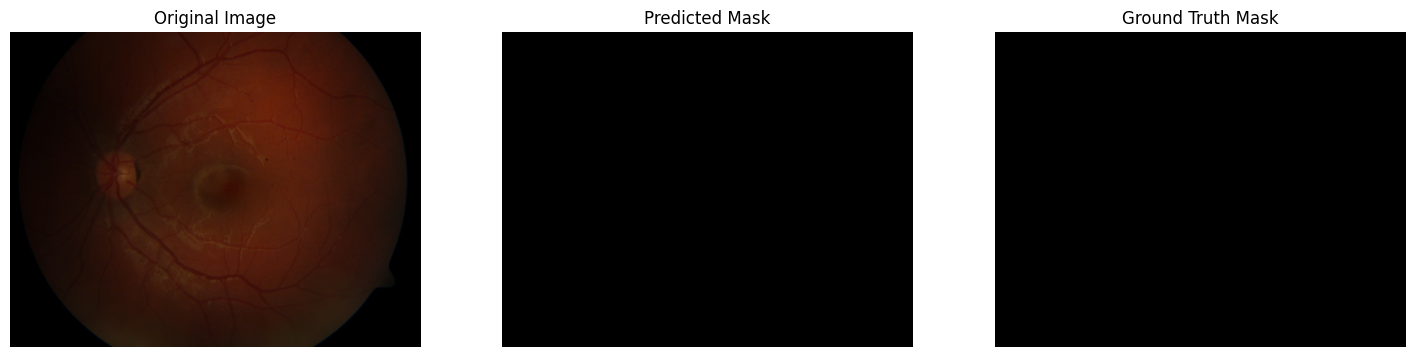

In [36]:
TEST_IMAGE_PATH = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images/image089.png"
MODEL_PATH = "/kaggle/working/unet_model.keras"
GROUND_TRUTH_PATH = "/kaggle/working/TestCombinedMasksTask1/image089.png"

# Image dimensions
IMG_HEIGHT = 1152
IMG_WIDTH = 1500

# Load the trained model
model = load_model(MODEL_PATH)

# Load and preprocess the test image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    original_size = image.shape[:2]  # Save original size for resizing prediction
    image_resized = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    return image, image_resized.reshape(1, IMG_HEIGHT, IMG_WIDTH, 3), original_size

original_image, preprocessed_image, original_size = load_and_preprocess_image(TEST_IMAGE_PATH)

# Predict the mask
predicted_mask = model.predict(preprocessed_image)[0]
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)  # Threshold to get binary mask

# Resize prediction to original size
predicted_mask_resized = cv2.resize(predicted_mask, (original_size[1], original_size[0]))

# Load ground truth image
ground_truth_image = cv2.imread(GROUND_TRUTH_PATH, cv2.IMREAD_GRAYSCALE)
ground_truth_image_resized = cv2.resize(ground_truth_image, (original_size[1], original_size[0]))

# Plot the results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_image_resized, cmap='gray')
plt.axis('off')

plt.show()

In [142]:
def data_patches(image_data):
    # Define patch size
    patch_size = 8

    # Get the dimensions of the image
    num_rows, num_cols, num_bands = image_data.shape

    # Initialize an empty list to store patches
    patches = []

    # Loop over the image in patches of 16x16
    for row in range(0, num_rows, patch_size):
        for col in range(0, num_cols, patch_size):
            # Extract the patch
            patch = image_data[row:row+patch_size, col:col+patch_size]

            # Check if the patch has the right shape (i.e., it's not on the edge)
            if patch.shape[:2] == (patch_size, patch_size):
                patches.append(patch)

    # Convert list of patches to numpy array
    patches_array = np.array(patches)
    return patches_array

In [45]:
train_patches = []

for a in X_train:
    patches = data_patches(a)
    train_patches.append(patches)

train_patches = np.concatenate(train_patches, axis=0)
train_patches.shape

(3150576, 8, 8, 3)

In [48]:
validation_patches = []
for a in X_val:
    patches = data_patches(a)
    validation_patches.append(patches)

validation_patches = np.concatenate(validation_patches, axis=0)
validation_patches.shape

(350064, 8, 8, 3)

In [49]:
def label_patches(image):
    patch_size = 8
    labeled_patches = []  # List to hold the label of each patch

    # Loop over the image in patches of 8x8
    for row in range(0, image.shape[0], patch_size):
        for col in range(0, image.shape[1], patch_size):
            # Extract the patch
            patch = image[row:row + patch_size, col:col + patch_size]

            # Check if the patch has the correct shape (i.e., it's not on the edge)
            if patch.shape[:2] == (patch_size, patch_size):
                # Flatten the patch and calculate the most frequent value (label)
                flattened_patch = patch.flatten()
                counts = np.bincount(flattened_patch)
                most_frequent = np.argmax(counts)
                labeled_patches.append(most_frequent)  # Append label of the patch

    return np.array(labeled_patches)

In [100]:
def label_patches2(image):
    patch_size = 8
    labeled_patches = []  # List to hold the label of each patch

    # Loop over the image in patches of 8x8
    for row in range(0, image.shape[0], patch_size):
        for col in range(0, image.shape[1], patch_size):
            # Extract the patch
            patch = image[row:row + patch_size, col:col + patch_size]

            # Check if the patch has the correct shape (i.e., it's not on the edge)
            if patch.shape[:2] == (patch_size, patch_size):
                # Check if there is at least one pixel with the value 1
                if 1 in patch:
                    labeled_patches.append(1)
                else:
                    labeled_patches.append(0)

    return np.array(labeled_patches)

In [101]:
train_labels = []

for a in y_train:
    labels = label_patches2(a)
    train_labels.extend(labels)

train_labels = np.array(train_labels)
train_labels.shape

(3150576,)

In [102]:
validation_labels = []

for a in y_val:
    labels = label_patches2(a)
    validation_labels.extend(labels)

validation_labels = np.array(validation_labels)
validation_labels.shape

(350064,)

In [141]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=(16, 16, 3)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(1024, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2048, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary to check structure
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 16, 16, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 4, 4, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 4, 4, 2048)     │    18,876,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,087,042 (130.03 MB)

 Trainable params: 34,087,042 (130.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_patches, train_labels, validation_data=(validation_patches, validation_labels), epochs=10, batch_size=512)

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights which could be used in model.fit
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(train_labels),y=train_labels)

class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [117]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Setup the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Path where the model is saved
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Only save the model if 'val_accuracy' has improved
    mode='max',  # 'max' because we want to maximize validation accuracy
    verbose=1  # Optional: provides detailed logging about the saved models
)

# Fit the model using the previously defined training and validation data
history2 = model.fit(
    train_patches, 
    train_labels, 
    validation_data=(validation_patches, validation_labels),
    epochs=10,
    batch_size=512,
    class_weight=class_weights_dict,  # Include class weights here
    callbacks=[checkpoint]  # Include the checkpoint in the callbacks
)

Epoch 1/10
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7346 - loss: 0.7355
Epoch 1: val_accuracy improved from -inf to 0.77979, saving model to best_model.keras
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 171s 27ms/step - accuracy: 0.7347 - loss: 0.7355 - val_accuracy: 0.7798 - val_loss: 0.4484
Epoch 2/10
6153/6154 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8069 - loss: 0.6703
Epoch 2: val_accuracy improved from 0.77979 to 0.97947, saving model to best_model.keras
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 167s 27ms/step - accuracy: 0.8069 - loss: 0.6703 - val_accuracy: 0.9795 - val_loss: 0.1564
Epoch 3/10
6153/6154 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8290 - loss: 0.3911
Epoch 3: val_accuracy did not improve from 0.97947
6154/6154 ━━━━━━━━━━━━━━━━━━━━ 167s 27ms/step - accuracy: 0.8290 - loss: 0.3911 - val_accuracy: 0.8458 - val_loss: 0.3584
Epoch 4/10
6153/6154 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8301 - loss: 0.3891
Epoch 4: val_accuracy improved from 0.97947 to 0.982

In [118]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

In [63]:
IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images"
MASK_DIR = "/kaggle/working/TestCombinedMasksTask1"

IMG_HEIGHT = 1152
IMG_WIDTH = 1500
BATCH_SIZE = 1

def load_data(image_dir, mask_dir):
    image_filenames = sorted(os.listdir(image_dir))
    images = []
    masks = []
    
    for filename in tqdm(image_filenames, desc="Loading data"):
        # Load and resize image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path)
        #image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        images.append(image)  # Normalize image to [0, 1]
        
        # Load and resize mask
        mask_path = os.path.join(mask_dir, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        #mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
        mask = (mask > 0).astype(np.uint8)  # Binarize mask (0 or 1)
        masks.append(mask)
    
    return np.array(images), np.array(masks).reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

X_test, y_test = load_data(IMAGE_DIR, MASK_DIR)

Loading data: 100%|██████████| 89/89 [00:06<00:00, 14.00it/s]


In [64]:
test_patches = []

for a in X_test:
    patches = data_patches(a)
    test_patches.append(patches)

test_patches = np.concatenate(test_patches, axis=0)
test_patches.shape

(2396592, 8, 8, 3)

In [119]:
test_labels = []

for a in y_test:
    labels = label_patches2(a)
    test_labels.extend(labels)

test_labels = np.array(test_labels)
test_labels.shape

(2396592,)

In [120]:
model.evaluate(test_patches,test_labels)

74894/74894 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.9964 - loss: 0.3270


[0.3323325216770172, 0.9976721405982971]

In [121]:
predictions = model.predict(test_patches)

74894/74894 ━━━━━━━━━━━━━━━━━━━━ 126s 2ms/step


In [122]:
predict = [np.argmax(a) for a in predictions]
predict[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [123]:
pred = []
for x in predict:
  pred.append(np.full((8, 8), x))
pred = np.array(pred)

In [124]:
pred2 = pred.reshape(89, 26928, 8, 8)

In [125]:
pred2[0].shape

(26928, 8, 8)

In [126]:
predicted_masks = []
for a in pred2:
    patches_per_row = 187
    patches_per_col = len(a) // patches_per_row
    image = np.concatenate([np.concatenate(a[i:i+patches_per_row], axis=1) for i in range(0, len(a), patches_per_row)], axis=0)
    predicted_masks.append(image)

In [127]:
len(predicted_masks)

89

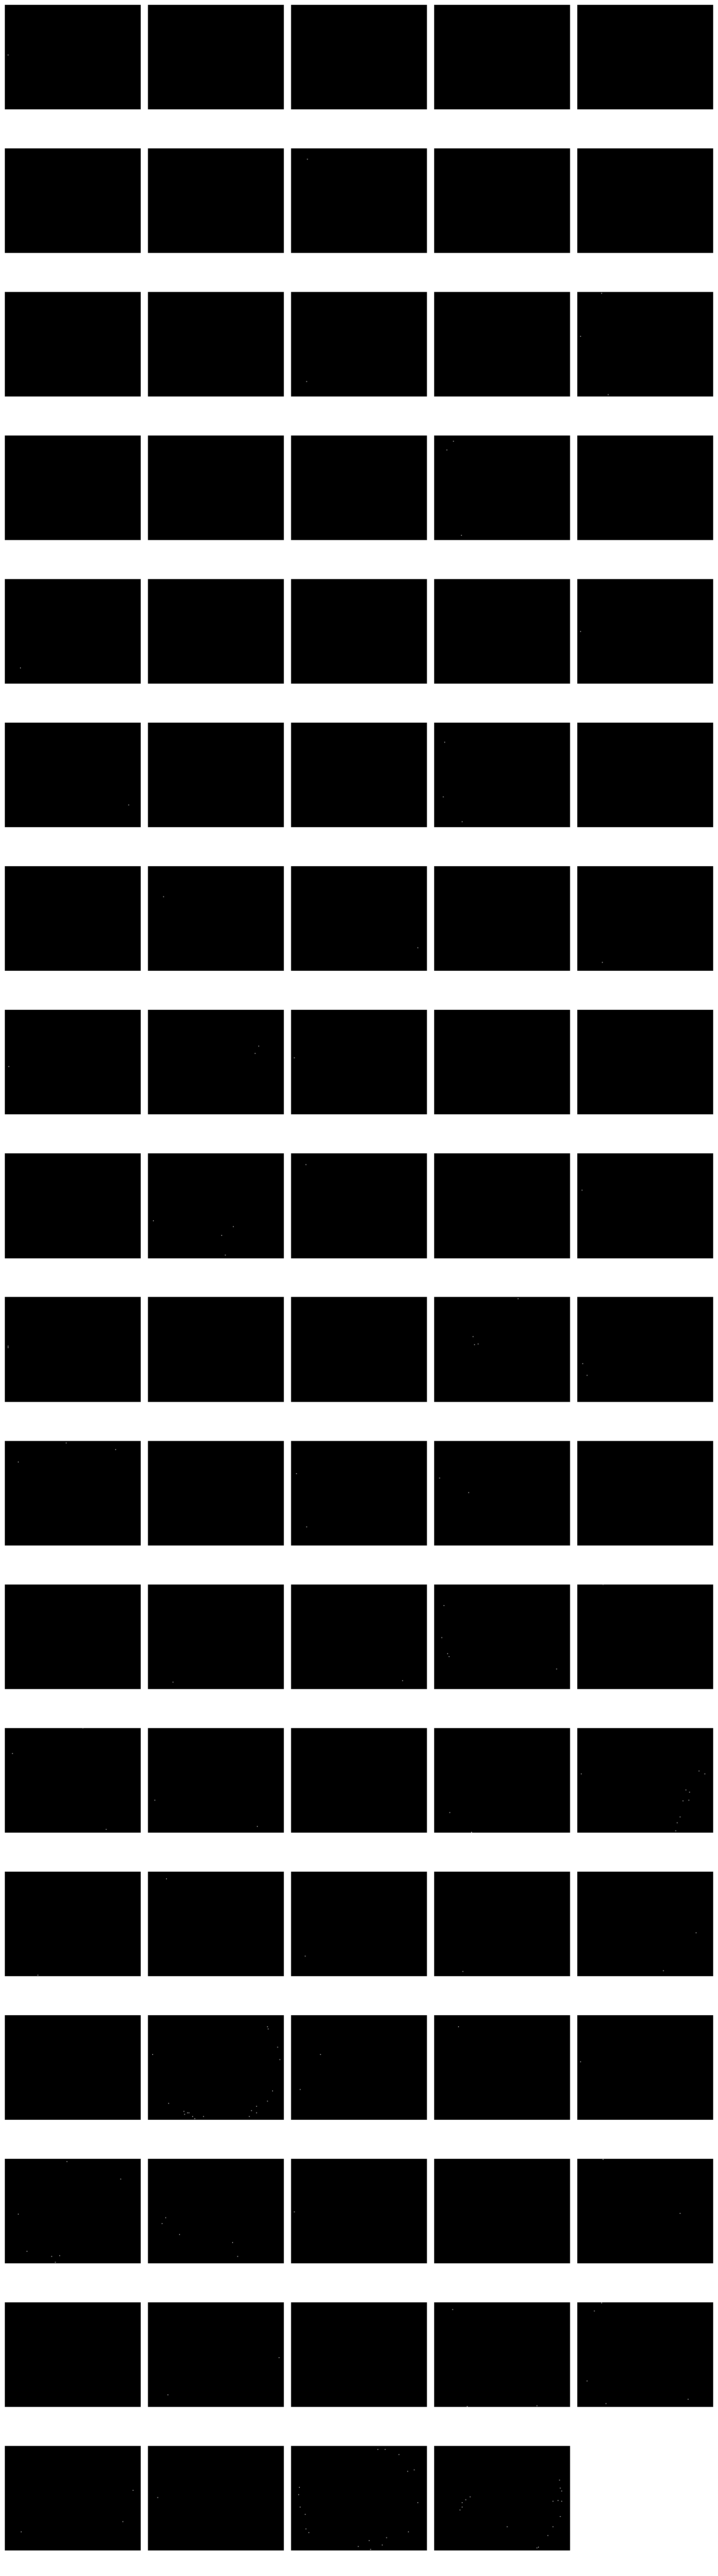

In [139]:
import matplotlib.pyplot as plt

# Assuming 'predicted_masks' is your list or array of images
num_images = 89
rows = 18
cols = 5

fig, axes = plt.subplots(rows, cols, figsize=(15, 54))  # Adjust figsize to your screen/display size
axes = axes.flatten()  # Flatten the 2D array of axes to simplify the looping

# Loop over all of the positions in the grid
for i in range(rows * cols):
    if i < num_images:
        # Display image
        axes[i].imshow(predicted_masks[i], cmap='gray')  # Assuming masks are grayscale
        axes[i].axis('off')  # Turn off axis numbering and ticks
    else:
        axes[i].axis('off')  # Make sure empty plots also have no axes

plt.tight_layout()  # Optional, improves spacing between plots
plt.show()

In [ ]:
from sklearn.utils import class_weight

# Calculate class weights which could be used in model.fit
class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_labels),
    train_labels)

class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

# Use class weights in the training process
history2 = model.fit(
    train_patches, 
    train_labels, 
    validation_data=(validation_patches, validation_labels),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict  # Include class weights here
)

In [ ]:
pip install segmentation-models
pip install tensorflow==2.8 keras==2.8

# New Nodel


# ***importing Libraries***

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.metrics import MeanIoU
num_classes = 5

# ***Loading Data***

In [ ]:
# Dataset directories
TRAIN_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/Images"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB0/Images"
TRAIN_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB0/GroundTruth"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB0/GroundTruth"

TEST_IMAGE_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/Images"  # e.g., "diabetic-retinopathy-dataset/Daataset DR/DB1/Images"
TEST_MASK_DIR = "/kaggle/input/diabetic-retinopathy-dataset/Daataset DR/DB1/GroundTruth"      # Replace with your testing mask directory

img_size = 256

OUTPUT_SIZE = (img_size, img_size)
iou_metric = MeanIoU(num_classes=num_classes)

In [ ]:

os.remove('/kaggle/working/unet_model2.keras')

# ***Data Preprocessing***

## ***Combining Masks into separate channels***

In [ ]:
# Combining Masks into separate channels
def combine_masks(cws_path, h_path, he_path, ma_path):
    cws = cv2.imread(cws_path, cv2.IMREAD_GRAYSCALE)
    h = cv2.imread(h_path, cv2.IMREAD_GRAYSCALE)
    he = cv2.imread(he_path, cv2.IMREAD_GRAYSCALE)
    ma = cv2.imread(ma_path, cv2.IMREAD_GRAYSCALE)
    
    target_shape=(cws.shape[0], cws.shape[1], 5)
    mask = np.zeros(target_shape, dtype=np.uint8)
    mask[:, :, 1] = (cws > 0)  # Class 1
    mask[:, :, 2] = (h > 0)    # Class 2
    mask[:, :, 3] = (he > 0)   # Class 3
    mask[:, :, 4] = (ma > 0)   # Class 4
    mask[:, :, 0] = (1 - np.sum(mask[:, :, :4], axis=-1))  # Background
    return mask


In [ ]:
# Preprocess Data
def preprocess_data(image_dir, mask_dir, size=(img_size, img_size)):
    images = []
    masks = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        base_name = os.path.splitext(image_file)[0]
        mask_cws = os.path.join(mask_dir, "CWS", base_name + ".png")
        mask_h = os.path.join(mask_dir, "H", base_name + ".png")
        mask_he = os.path.join(mask_dir, "HE", base_name + ".png")
        mask_ma = os.path.join(mask_dir, "MA", base_name + ".png")

        # Read and resize images and masks
        image = cv2.imread(image_path)
        
        # Color BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size) / 255.0
        
        mask = combine_masks(mask_cws, mask_h, mask_he, mask_ma)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

## ***Loading the Data***

In [ ]:
from tensorflow.keras.utils import to_categorical
train_images, train_masks = preprocess_data(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, size=OUTPUT_SIZE)
test_images, test_masks = preprocess_data(TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE)

In [ ]:
train_masks.shape, test_masks.shape

In [ ]:
train_images.shape, test_images.shape

## ***Augmentation***

In [ ]:
import albumentations as A
from albumentations.core.composition import OneOf
from tensorflow.keras.utils import to_categorical

In [ ]:
# Data Augmentation Function
def augment_data(image, mask):
    # Define the augmentation pipeline
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),  # Random horizontal flip
        A.VerticalFlip(p=0.5),    # Random vertical flip
        A.Rotate(limit=30, p=0.5), # Random rotation
        A.RandomBrightnessContrast(p=0.2),  # Adjust brightness and contrast
    ])
    
    # Apply augmentations
    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Preprocess and Augment Data
def preprocess_data_with_augmentation(image_dir, mask_dir, size=(img_size, img_size), augment=False):
    images = []
    masks = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        base_name = os.path.splitext(image_file)[0]
        mask_cws = os.path.join(mask_dir, "CWS", base_name + ".png")
        mask_h = os.path.join(mask_dir, "H", base_name + ".png")
        mask_he = os.path.join(mask_dir, "HE", base_name + ".png")
        mask_ma = os.path.join(mask_dir, "MA", base_name + ".png")

        # Read and resize images and masks
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, size) / 255.0
        
        mask = combine_masks(mask_cws, mask_h, mask_he, mask_ma)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

        if augment:
            image, mask = augment_data(image, mask)

        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

# Load and Augment Training Data
train_images_2, train_masks_2 = preprocess_data_with_augmentation(
    TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, size=OUTPUT_SIZE, augment=True
)
"""
# Load Testing Data (no augmentation)
test_images, test_masks = preprocess_data_with_augmentation(
    TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE, augment=False
)
"""

pass

In [ ]:
train_images_2.shape, train_masks_2.shape

### ***Combine Augmented images with original***

In [ ]:
# Combine Augmented images with original
combined_train_images = np.concatenate((train_images, train_images_2), axis=0)
combined_train_masks = np.concatenate((train_masks, train_masks_2), axis=0)
del train_images_2, train_masks_2, train_images, train_masks, A, OneOf

In [ ]:
combined_train_images.shape, combined_train_masks.shape

## ***One-Hot Encoding***

In [ ]:
# Convert masks to categorical format
# No need in current Implementation
categorical_train_mask = to_categorical(combined_train_masks, num_classes=num_classes)
categorical_test_mask = to_categorical(test_masks, num_classes=num_classes)
categorical_train_mask.shape, categorical_test_mask.shape

# ***Pretrained Model***

In [ ]:
!pip install keras-unet-collection

In [ ]:
from keras_unet_collection import models
# e.g. models.unet_2d(...)

In [ ]:
unet = models.unet_3plus_2d(input_size=(img_size, img_size, 3), n_labels=5, filter_num_down=[128, 256, 512], backbone='VGG16', weights='imagenet', freeze_backbone=True, output_activation= 'Softmax')

In [ ]:
unet.summary()

# Custom Unet

In [ ]:
from tensorflow.keras.regularizers import l2
# Define U-Net Model
def custom_unet(input_shape=(img_size, img_size, 3), num_classes=num_classes):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), dilation_rate=(2, 2))(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    """
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', dilation_rate=(2, 2))(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c4)
    """
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p2)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c4)
    
    # Decoder
    """
    u6 = UpSampling2D((2, 2))(c4)
    u6 = Concatenate()([u6, c3])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    """
    
    u7 = UpSampling2D((2, 2))(c4)
    u7 = Concatenate()([u7, c2])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c1])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), padding='same')(c8)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c8)

    model = Model(inputs, outputs)
    
    return model
# Build U-Net model
model = custom_unet(input_shape=(img_size, img_size, 3), num_classes=num_classes)
model.compile(optimizer='adam',
              loss=jaccard_loss,
              metrics=[iou_metric])

# Callbacks
#checkpoint = ModelCheckpoint("unet_model2.keras", save_best_only=True, monitor="val_loss")
#early_stopping = EarlyStopping(patience=10, monitor="val_loss")
model.summary()

# ***Computing Class Weights***

In [ ]:
from keras_unet_collection.losses import dice, dice_coef, iou_seg

In [ ]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(np.argmax(combined_train_masks, axis=-1).flatten()), 
    y=np.argmax(test_masks, axis=-1).flatten()
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
class_weight_dict

## ***Sample Weights***

In [ ]:
############ For Losses other than CrossEntropy loss  ##############
def compute_sample_weights(masks, class_weight_dict):
    flattened_masks = masks.reshape(-1)
    sample_weights = np.array([class_weight_dict.get(int(label), 1.0) for label in flattened_masks])
    return sample_weights.reshape(masks.shape)

In [ ]:
##########    For CrossEntropy Loss  ###################

def compute_sample_weights(masks, class_weight_dict):
    """
    Computes sample weights based on the class weights for each pixel.

    Args:
        masks: Numpy array of ground truth masks (categorical, one-hot or index-based).
        class_weight_dict: Dictionary mapping class indices to weights.

    Returns:
        Numpy array of sample weights with shape (batch_size, height, width).
    """
    if masks.ndim == 4:  
        masks = np.argmax(masks, axis=-1) 
    sample_weights = np.zeros_like(masks, dtype=np.float32)
    for class_idx, weight in class_weight_dict.items():
        sample_weights[masks == class_idx] = weight
    
    return sample_weights

# Model Training

In [ ]:

# Create the LearningRateScheduler callback
#lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

unet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[iou_metric])
# Train the Model
def train_model(model = None, t_img = None, t_mask= None,
                valid_img=None, valid_mask= None ):
    
    # Train the model
    sample_weights = compute_sample_weights(t_mask, class_weight_dict)
    
    history = model.fit(x=t_img, y=t_mask,
                        validation_data=(valid_img, valid_mask),
                        epochs=10,
                        batch_size=8,
                        shuffle=True,
                        sample_weight=sample_weights,
                        ) # callbacks=[lr_scheduler]

    return model, history

# Run Training and Testing
if __name__ == "__main__":
    model, history = train_model(model= unet, t_img=combined_train_images, t_mask=combined_train_masks,
                                 valid_img= test_images, valid_mask=test_masks)

In [ ]:
# Save Model
model.save('/kaggle/working/01Model_U3Plus.keras')

## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def plot_confusion_matrix(model, test_images, test_masks, num_classes):
    """
    Generate and plot the confusion matrix for the multi-class segmentation task.

    Args:
        model: Trained Keras model.
        test_images: Array of test images.
        test_masks: Array of true masks for test data (one-hot or class indices).
        num_classes: Number of classes in the segmentation task.
    """
    predictions = model.predict(test_images, batch_size=8)
    predicted_labels = np.argmax(predictions, axis=-1)  
    if test_masks.ndim == 4:  
        test_masks = np.argmax(test_masks, axis=-1) 

    true_labels = test_masks.flatten()
    predicted_labels = predicted_labels.flatten()

    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=list(range(num_classes)))
    disp.plot(ax=ax, cmap='viridis', values_format='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.show()

test_images, test_masks = preprocess_data(TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE)

# Plot the confusion matrix
plot_confusion_matrix(model, test_images, test_masks, num_classes)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_images, test_masks, num_classes):
    """
    Generate and plot the confusion matrix for the multi-class segmentation task.

    Args:
        model: Trained Keras model.
        test_images: Array of test images.
        test_masks: Array of true masks for test data (one-hot or class indices).
        num_classes: Number of classes in the segmentation task.
    """
    # Predict masks
    predictions = model.predict(test_images, batch_size=8)
    predicted_labels = np.argmax(predictions, axis=-1)  
    
    # Convert one-hot masks to class indices
    if test_masks.ndim == 4:  
        test_masks = np.argmax(test_masks, axis=-1) 

    # Flatten the labels for confusion matrix computation
    true_labels = test_masks.flatten()
    predicted_labels = predicted_labels.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_classes)))
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    # Plot the normalized confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=list(range(num_classes)))
    disp.plot(ax=ax, cmap='viridis', values_format='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.show()

# Preprocess test data
test_images, test_masks = preprocess_data(TEST_IMAGE_DIR, TEST_MASK_DIR, size=OUTPUT_SIZE)

# Plot the confusion matrix
plot_confusion_matrix(model, test_images, test_masks, num_classes)


## Inference

In [ ]:
def inference(path=None, image_size = 256, model=None):
    im = cv2.imread(path, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (image_size, img_size))
    pred = model.predict(np.expand_dims(image, axis=0))[0]
    mask = np.argmax(pred, axis=-1)
    return mask

path = ''
mask = inference(im, image_size=img_size, model)
plt.imshow(mask, cmap='gray')

In [ ]:
np.unique(mask)

In [ ]:
true_mask = mask
true_mask.flatten()
pixel_counts = np.bincount(true_mask.flatten())

# Print the pixel counts for each class (excluding b ackground if it's class 0)
for class_idx, count in enumerate(pixel_counts):
    print(f"Class {class_idx}: {count} pixels")